<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week10/UCI_HAR_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# optim.lr_scheduler 임포트 추가
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import math
import os

In [24]:
# --- 1. 설정 및 데이터 전처리 ---

# CUDA 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# !!! 중요 !!!
# UCI HAR Dataset 폴더가 있는 경로를 지정해주세요.
# 예: '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/UCI HAR Dataset/'
# 예: './UCI HAR Dataset/'
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset' # 이 부분을 사용자의 환경에 맞게 수정하세요.

# 하위 폴더 경로 설정
TRAIN_PATH = os.path.join(DATA_PATH, 'train/')
TEST_PATH = os.path.join(DATA_PATH, 'test/')

Using device: cuda


In [25]:
# 원본 Keras 코드의 데이터 로딩 함수 (Pandas 경고 수정)
def load_file(filepath):
    # delim_whitespace=True 대신 sep='\s+' 사용
    dataframe = pd.read_csv(filepath, header=None, sep=r'\s+')
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = os.path.join(prefix, group, 'Inertial Signals/')
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(os.path.join(prefix, group, 'y_'+group+'.txt'))
    return X, y

def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix)
    # load all test
    testX, testy = load_dataset_group('test', prefix)

    # zero-offset class values (1-6 -> 0-5)
    trainy = trainy - 1
    testy = testy - 1

    # PyTorch CrossEntropyLoss는 원-핫 인코딩이 필요 없음.

    print(f"trainX shape: {trainX.shape}, trainy shape: {trainy.shape}")
    print(f"testX shape: {testX.shape}, testy shape: {testy.shape}")

    return trainX, trainy, testX, testy

# 데이터 로드
trainX, trainy, testX, testy = load_dataset(DATA_PATH)

# Train 데이터를 Train/Validation으로 분리
# trainy_one_hot 대신 trainy (레이블 인덱스) 사용
X_train, X_val, y_train, y_val = train_test_split(
    trainX, trainy, test_size=0.2, random_state=42, stratify=trainy
)

# NumPy array를 PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.flatten(), dtype=torch.long) # CrossEntropyLoss를 위해 long 타입 및 1D로 변환
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.flatten(), dtype=torch.long)
X_test_tensor = torch.tensor(testX, dtype=torch.float32)
y_test_tensor = torch.tensor(testy.flatten(), dtype=torch.long)

# 데이터셋 및 데이터로더 생성
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 모델 입력 파라미터 정의
N_TIMESTEPS = X_train.shape[1]  # 128
N_FEATURES = X_train.shape[2]   # 9
N_OUTPUTS = len(np.unique(trainy)) # 6

print(f"Timesteps: {N_TIMESTEPS}, Features: {N_FEATURES}, Outputs: {N_OUTPUTS}")

trainX shape: (7352, 128, 9), trainy shape: (7352, 1)
testX shape: (2947, 128, 9), testy shape: (2947, 1)
Timesteps: 128, Features: 9, Outputs: 6


In [26]:
# --- 2. 모델 정의 (PyTorch) ---

# 1. Simple 1D CNN -> 원본 Keras 모델(Inception-style)로 교체
class InceptionTimeModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_filters=32):
        super(InceptionTimeModel, self).__init__()

        # Keras 모델은 채널 수를 128 -> 64 -> 32 로 줄였습니다.
        # 여기서는 간단하게 32필터로 3개 층을 구현합니다.

        # Keras의 첫 번째 블록 (커널 3, 5, 7, 9 -> 128 필터)
        self.conv_block1 = self._make_inception_block(input_dim, num_filters * 4) # 128

        # Keras의 두 번째 블록 (-> 64 필터)
        # Keras 모델은 concatenate(axis=1) 후 MaxPooling(5)를 사용했습니다.
        # PyTorch에서는 Conv1d의 stride=2로 다운샘플링하는 것이 더 일반적입니다.
        self.conv_block2 = self._make_inception_block(num_filters * 4, num_filters * 2, stride=2) # 64

        # Keras의 세 번째 블록 (-> 32 필터)
        self.conv_block3 = self._make_inception_block(num_filters * 2, num_filters, stride=2) # 32

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()

        # Keras의 Dense(512)
        self.fc1 = nn.Linear(num_filters, 128) # 32 -> 128
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_dim)

    def _make_inception_block(self, in_channels, out_channels_per_branch, stride=1):
        # Keras 모델은 4개의 다른 커널 크기를 사용했습니다. (3, 5, 7, 9)
        # 좀 더 표준적인 InceptionTime은 (3, 5, 7)을 사용합니다.
        # Keras 모델을 충실히 따르기 위해 (3, 5, 7, 9)를 사용합니다.

        # Keras의 concatenate(axis=1)는 (N, L, C) 기준이므로,
        # PyTorch (N, C, L) 기준에서는 concatenate(axis=2)입니다.

        # PyTorch의 Conv1d는 (N, C, L)을 받으므로,
        # (N, L, C) -> (N, C, L)로 permute가 필요합니다.

        # Keras 모델은 4개의 개별 입력을 받았지만, 여기서는 1개 입력을 4개 브랜치로 나눕니다.
        # Keras는 각 브랜치가 128(out)을 가졌지만, 여기서는 32*4=128(out)이 되도록 out_channels_per_branch를 32로 설정합니다.

        # 각 브랜치의 출력 채널 수
        branch_channels = out_channels_per_branch // 4

        # Kernel 3
        self.branch1 = nn.Conv1d(in_channels, branch_channels, kernel_size=3, stride=stride, padding=1)
        # Kernel 5
        self.branch2 = nn.Conv1d(in_channels, branch_channels, kernel_size=5, stride=stride, padding=2)
        # Kernel 7
        self.branch3 = nn.Conv1d(in_channels, branch_channels, kernel_size=7, stride=stride, padding=3)
        # Kernel 9
        self.branch4 = nn.Conv1d(in_channels, branch_channels, kernel_size=9, stride=stride, padding=4)

        # Batch Norm 추가 (성능 안정화)
        self.bn = nn.BatchNorm1d(out_channels_per_branch)
        self.relu = nn.ReLU()

        # Keras와 달리, PyTorch에서는 모듈 리스트나 Sequential을 사용해야 합니다.
        # nn.Module을 상속받는 별도 Block 클래스로 만듭니다.
        return InceptionBlock(in_channels, branch_channels, stride)

    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.permute(0, 2, 1)

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = self.global_avg_pool(x)
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Inception 블록 헬퍼 클래스
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, branch_channels, stride=1):
        super(InceptionBlock, self).__init__()

        # Kernel 3
        self.branch1 = nn.Conv1d(in_channels, branch_channels, kernel_size=3, stride=stride, padding=1)
        # Kernel 5
        self.branch2 = nn.Conv1d(in_channels, branch_channels, kernel_size=5, stride=stride, padding=2)
        # Kernel 7
        self.branch3 = nn.Conv1d(in_channels, branch_channels, kernel_size=7, stride=stride, padding=3)
        # Kernel 9
        self.branch4 = nn.Conv1d(in_channels, branch_channels, kernel_size=9, stride=stride, padding=4)

        # (N, C, L) 기준이므로, dim=1 (Channel dimension)에서 concat
        self.bn = nn.BatchNorm1d(branch_channels * 4)
        self.relu = nn.ReLU()

        # Keras의 concatenate(axis=1)는 (N, L, C) 기준이었습니다.
        # PyTorch (N, C, L) 기준에서는 dim=1 (Channels)에서 합쳐야 합니다.

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)

        # (N, C, L) 기준, 채널(dim=1) 축으로 concatenate
        x = torch.cat([b1, b2, b3, b4], dim=1)

        x = self.bn(x)
        x = self.relu(x)
        return x

# 원본 Keras 모델의 3-stack Inception-like 구조
class OriginalKerasCNN(nn.Module):
    def __init__(self, input_dim, output_dim, f1=128, f2=64, f3=32):
        super(OriginalKerasCNN, self).__init__()

        # Keras 모델은 4개의 개별 입력을 받았지만, PyTorch에서는 1개 입력을 공유
        # (N, L, C) -> (N, C, L)
        self.branch1_1 = nn.Conv1d(input_dim, f1, kernel_size=3) # padding=0
        self.branch1_2 = nn.Conv1d(input_dim, f1, kernel_size=5)
        self.branch1_3 = nn.Conv1d(input_dim, f1, kernel_size=7)
        self.branch1_4 = nn.Conv1d(input_dim, f1, kernel_size=9)
        self.relu1 = nn.ReLU()
        # Keras:
        # conv1_1: (N, 126, 128)
        # conv1_2: (N, 124, 128)
        # conv1_3: (N, 122, 128)
        # conv1_4: (N, 120, 128)
        # merged_1 (axis=1): (N, 492, 128)
        # pool_1 (pool=5): (N, 98, 128) -> (N, 128, 98) in PyTorch (permuted)

        # Keras의 axis=1 concat은 (N, L, C) 기준 (L을 합침)
        # PyTorch의 (N, C, L) 기준에서는 axis=2 concat (L을 합침)
        self.pool1 = nn.MaxPool1d(kernel_size=5)

        # Layer 2
        self.branch2_1 = nn.Conv1d(f1, f2, kernel_size=3)
        self.branch2_2 = nn.Conv1d(f1, f2, kernel_size=5)
        self.branch2_3 = nn.Conv1d(f1, f2, kernel_size=7)
        self.branch2_4 = nn.Conv1d(f1, f2, kernel_size=9)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=5)

        # Layer 3
        self.branch3_1 = nn.Conv1d(f2, f3, kernel_size=3)
        self.branch3_2 = nn.Conv1d(f2, f3, kernel_size=5)
        self.branch3_3 = nn.Conv1d(f2, f3, kernel_size=7)
        self.branch3_4 = nn.Conv1d(f2, f3, kernel_size=9)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=5)

        self.flatten = nn.Flatten()

        # Keras의 Flatten() (N, 55, 32) -> (N, 1760)
        # PyTorch (N, 32, 55) -> (N, 1760)

        # Keras 모델의 Flattened size 계산 (중요)
        # L1: In(128) -> Out(126, 124, 122, 120) -> Cat(492) -> Pool5(98)
        # L2: In(98) -> Out(96, 94, 92, 90) -> Cat(372) -> Pool5(74)
        # L3: In(74) -> Out(72, 70, 68, 66) -> Cat(276) -> Pool5(55)
        # Flattened: 55 * 32 = 1760

        self.fc1 = nn.Linear(1760, 512)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(512, output_dim)

    def forward(self, x):
        # x: (N, L, C) -> (N, C, L)
        x_permuted = x.permute(0, 2, 1) # (N, 9, 128)

        # Layer 1
        # Keras는 input (N, L, C) = (N, 128, 9)
        # PyTorch는 input (N, C, L) = (N, 9, 128)
        b1_1 = self.relu1(self.branch1_1(x_permuted)) # (N, 128, 126)
        b1_2 = self.relu1(self.branch1_2(x_permuted)) # (N, 128, 124)
        b1_3 = self.relu1(self.branch1_3(x_permuted)) # (N, 128, 122)
        b1_4 = self.relu1(self.branch1_4(x_permuted)) # (N, 128, 120)

        # Keras의 (N, L, C) 기준 axis=1 (L) concat
        # PyTorch의 (N, C, L) 기준 axis=2 (L) concat
        c1 = torch.cat([b1_1, b1_2, b1_3, b1_4], dim=2) # (N, 128, 492)
        p1 = self.pool1(c1) # (N, 128, 98)

        # Layer 2
        b2_1 = self.relu2(self.branch2_1(p1)) # (N, 64, 96)
        b2_2 = self.relu2(self.branch2_2(p1)) # (N, 64, 94)
        b2_3 = self.relu2(self.branch2_3(p1)) # (N, 64, 92)
        b2_4 = self.relu2(self.branch2_4(p1)) # (N, 64, 90)
        c2 = torch.cat([b2_1, b2_2, b2_3, b2_4], dim=2) # (N, 64, 372)
        p2 = self.pool2(c2) # (N, 64, 74)

        # Layer 3
        b3_1 = self.relu3(self.branch3_1(p2)) # (N, 32, 72)
        b3_2 = self.relu3(self.branch3_2(p2)) # (N, 32, 70)
        b3_3 = self.relu3(self.branch3_3(p2)) # (N, 32, 68)
        b3_4 = self.relu3(self.branch3_4(p2)) # (N, 32, 66)
        c3 = torch.cat([b3_1, b3_2, b3_3, b3_4], dim=2) # (N, 32, 276)
        p3 = self.pool3(c3) # (N, 32, 55)

        # Flatten
        flat = self.flatten(p3) # (N, 32 * 55 = 1760)

        # Dense
        fc1_out = self.relu_fc(self.fc1(flat))
        out = self.fc2(fc1_out)
        return out

# 2. LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=0.2)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (N, L, C) - batch_first=True

        # h_n shape: (num_layers, N, hidden_dim)
        _, (h_n, _) = self.lstm(x)

        # 마지막 레이어의 마지막 hidden state 사용
        # (N, hidden_dim)
        out = h_n[-1, :, :]
        out = self.fc(out)
        return out

# 3. GRU
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=0.2)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # h_n shape: (num_layers, N, hidden_dim)
        _, h_n = self.gru(x)

        # 마지막 레이어의 마지막 hidden state 사용
        out = h_n[-1, :, :]
        out = self.fc(out)
        return out

# 4. CNN + LSTM
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_dim, conv_out, hidden_dim, output_dim, num_lstm_layers):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=conv_out, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # CNN 출력 (N, conv_out, N_TIMESTEPS // 2)
        # LSTM 입력 (N, L, C)
        self.lstm = nn.LSTM(conv_out, hidden_dim, num_lstm_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.permute(0, 2, 1)
        x = self.pool1(self.relu1(self.conv1(x)))

        # (N, C_conv, L_conv) -> (N, L_conv, C_conv)
        x = x.permute(0, 2, 1)

        _, (h_n, _) = self.lstm(x)

        out = h_n[-1, :, :]
        out = self.fc(out)
        return out

# 5. CNN + GRU
class CNN_GRU_Model(nn.Module):
    def __init__(self, input_dim, conv_out, hidden_dim, output_dim, num_gru_layers):
        super(CNN_GRU_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=conv_out, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.gru = nn.GRU(conv_out, hidden_dim, num_gru_layers,
                          batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.permute(0, 2, 1)
        x = self.pool1(self.relu1(self.conv1(x)))

        # (N, C_conv, L_conv) -> (N, L_conv, C_conv)
        x = x.permute(0, 2, 1)

        _, h_n = self.gru(x)

        out = h_n[-1, :, :]
        out = self.fc(out)
        return out

# 6. ResNet (1D)
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

class ResNet1D(nn.Module):
    def __init__(self, block, num_blocks, input_dim, output_dim):
        super(ResNet1D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, output_dim)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.permute(0, 2, 1)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

# 7. Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (N, L, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, n_head, num_encoder_layers, dim_feedforward, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model

        self.conv_embed = nn.Conv1d(input_dim, d_model, kernel_size=3, padding=1)

        self.pos_encoder = PositionalEncoding(d_model, max_len=N_TIMESTEPS + 1) # +1 for CLS token

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_head,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.fc_head = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # x: (N, L, C_in) = (N, 128, 9)

        x = x.permute(0, 2, 1)
        x = self.conv_embed(x)
        x = x.permute(0, 2, 1)

        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # (N, L+1, d_model)

        x = self.pos_encoder(x)

        x = self.transformer_encoder(x) # (N, L+1, d_model)

        cls_output = x[:, 0, :] # (N, d_model)

        out = self.fc_head(cls_output)
        return out

In [27]:
# --- 3. 학습 및 평가 함수 ---

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        loss.backward()

        # === !!! 수정된 부분 !!! ===
        # 그래디언트 폭주(exploding gradients) 방지를 위한 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # ==========================

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)

    return epoch_loss, epoch_acc.item()

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)

    return epoch_loss, epoch_acc.item()

# 테스트셋 전체에 대한 예측 및 실제 값 반환 (sklearn용)
def get_test_results(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [28]:
# --- 4. 모델 학습 및 평가 실행 ---

# 하이퍼파라미터
N_EPOCHS = 40 # 20 -> 40으로 증가
LEARNING_RATE = 0.001
HIDDEN_DIM = 128
NUM_LAYERS = 2

# 모델 정의
models = {
    # 1. Simple CNN -> OriginalKerasCNN (Inception-style)로 교체
    "1. Inception-Style CNN (Original)": OriginalKerasCNN(N_FEATURES, N_OUTPUTS),
    "2. LSTM": LSTMModel(N_FEATURES, HIDDEN_DIM, N_OUTPUTS, NUM_LAYERS),
    "3. GRU": GRUModel(N_FEATURES, HIDDEN_DIM, N_OUTPUTS, NUM_LAYERS),
    "4. CNN + LSTM": CNN_LSTM_Model(N_FEATURES, 64, HIDDEN_DIM, N_OUTPUTS, NUM_LAYERS),
    "5. CNN + GRU": CNN_GRU_Model(N_FEATURES, 64, HIDDEN_DIM, N_OUTPUTS, NUM_LAYERS),
    # ResNet18과 유사한 1D 구조 (num_blocks = [2, 2, 2, 2])
    "6. ResNet1D": ResNet1D(BasicBlock1D, [2, 2, 2, 2], N_FEATURES, N_OUTPUTS),
    "7. Transformer": TransformerModel(
        input_dim=N_FEATURES,
        d_model=64,
        n_head=4,
        num_encoder_layers=3,
        dim_feedforward=128,
        output_dim=N_OUTPUTS
    )
}


--- 🏋️ Training 1. Inception-Style CNN (Original) ---
Epoch 01/40 | Train Loss: 0.5789 | Train Acc: 0.7543 | Val Loss: 0.3048 | Val Acc: 0.8790
Epoch 02/40 | Train Loss: 0.1659 | Train Acc: 0.9350 | Val Loss: 0.1654 | Val Acc: 0.9375
Epoch 03/40 | Train Loss: 0.1250 | Train Acc: 0.9466 | Val Loss: 0.0944 | Val Acc: 0.9653
Epoch 04/40 | Train Loss: 0.1103 | Train Acc: 0.9510 | Val Loss: 0.0968 | Val Acc: 0.9599
Epoch 05/40 | Train Loss: 0.1093 | Train Acc: 0.9510 | Val Loss: 0.0921 | Val Acc: 0.9619
Epoch 06/40 | Train Loss: 0.0997 | Train Acc: 0.9548 | Val Loss: 0.0850 | Val Acc: 0.9667
Epoch 07/40 | Train Loss: 0.1020 | Train Acc: 0.9597 | Val Loss: 0.1146 | Val Acc: 0.9619
Epoch 08/40 | Train Loss: 0.0982 | Train Acc: 0.9609 | Val Loss: 0.1170 | Val Acc: 0.9545
Epoch 09/40 | Train Loss: 0.0890 | Train Acc: 0.9638 | Val Loss: 0.0748 | Val Acc: 0.9660
Epoch 10/40 | Train Loss: 0.0777 | Train Acc: 0.9651 | Val Loss: 0.0669 | Val Acc: 0.9742
Epoch 11/40 | Train Loss: 0.0656 | Train Acc:

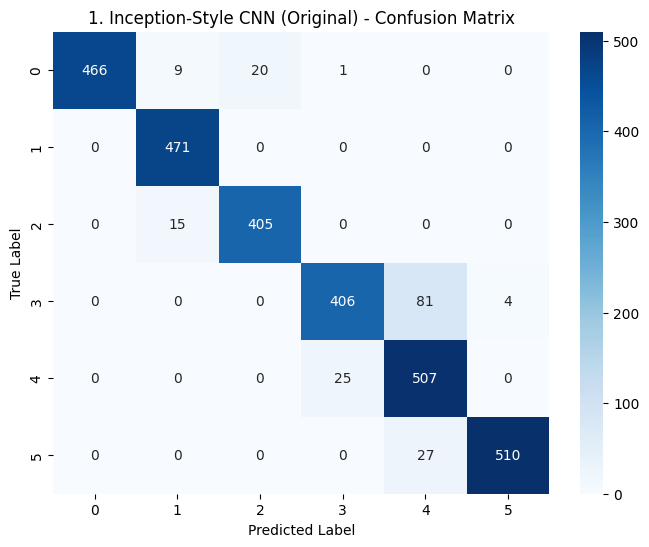


--- 🏋️ Training 2. LSTM ---
Epoch 01/40 | Train Loss: 1.3928 | Train Acc: 0.3890 | Val Loss: 1.2365 | Val Acc: 0.4528
Epoch 02/40 | Train Loss: 1.0149 | Train Acc: 0.5679 | Val Loss: 0.8352 | Val Acc: 0.6125
Epoch 03/40 | Train Loss: 0.7555 | Train Acc: 0.6569 | Val Loss: 0.7257 | Val Acc: 0.6519
Epoch 04/40 | Train Loss: 0.7494 | Train Acc: 0.6504 | Val Loss: 0.7290 | Val Acc: 0.6601
Epoch 05/40 | Train Loss: 0.7819 | Train Acc: 0.6370 | Val Loss: 0.6965 | Val Acc: 0.6567
Epoch 06/40 | Train Loss: 0.6375 | Train Acc: 0.7014 | Val Loss: 0.6649 | Val Acc: 0.6574
Epoch 07/40 | Train Loss: 0.6940 | Train Acc: 0.6478 | Val Loss: 0.6960 | Val Acc: 0.6934
Epoch 08/40 | Train Loss: 0.6873 | Train Acc: 0.6708 | Val Loss: 0.6260 | Val Acc: 0.7199
Epoch 09/40 | Train Loss: 0.6383 | Train Acc: 0.7240 | Val Loss: 0.5323 | Val Acc: 0.7804
Epoch 10/40 | Train Loss: 0.4715 | Train Acc: 0.7958 | Val Loss: 0.4103 | Val Acc: 0.8620
Epoch 11/40 | Train Loss: 0.3844 | Train Acc: 0.8614 | Val Loss: 0.3062

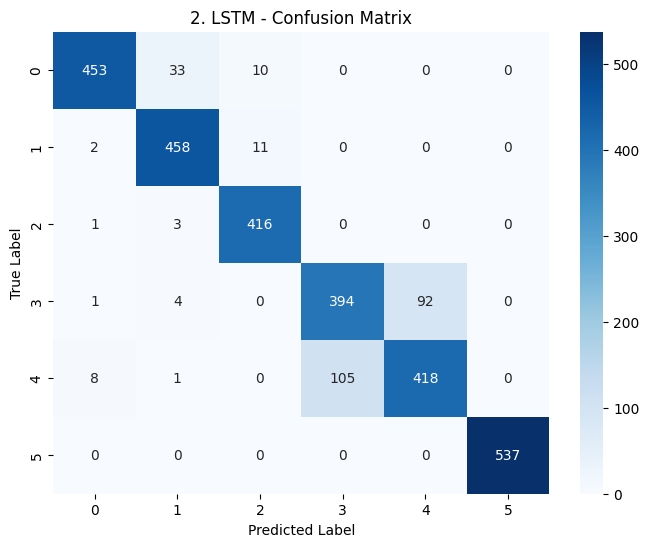


--- 🏋️ Training 3. GRU ---
Epoch 01/40 | Train Loss: 1.2187 | Train Acc: 0.4816 | Val Loss: 0.9540 | Val Acc: 0.5819
Epoch 02/40 | Train Loss: 0.7591 | Train Acc: 0.6820 | Val Loss: 0.5756 | Val Acc: 0.7593
Epoch 03/40 | Train Loss: 0.4389 | Train Acc: 0.8092 | Val Loss: 0.4112 | Val Acc: 0.8375
Epoch 04/40 | Train Loss: 0.3267 | Train Acc: 0.8798 | Val Loss: 0.2904 | Val Acc: 0.9001
Epoch 05/40 | Train Loss: 0.2074 | Train Acc: 0.9247 | Val Loss: 0.1801 | Val Acc: 0.9327
Epoch 06/40 | Train Loss: 0.1662 | Train Acc: 0.9393 | Val Loss: 0.1910 | Val Acc: 0.9239
Epoch 07/40 | Train Loss: 0.1643 | Train Acc: 0.9373 | Val Loss: 0.1437 | Val Acc: 0.9361
Epoch 08/40 | Train Loss: 0.1510 | Train Acc: 0.9407 | Val Loss: 0.1365 | Val Acc: 0.9572
Epoch 09/40 | Train Loss: 0.1362 | Train Acc: 0.9478 | Val Loss: 0.1147 | Val Acc: 0.9504
Epoch 10/40 | Train Loss: 0.1332 | Train Acc: 0.9468 | Val Loss: 0.1223 | Val Acc: 0.9545
Epoch 11/40 | Train Loss: 0.1318 | Train Acc: 0.9490 | Val Loss: 0.1152 

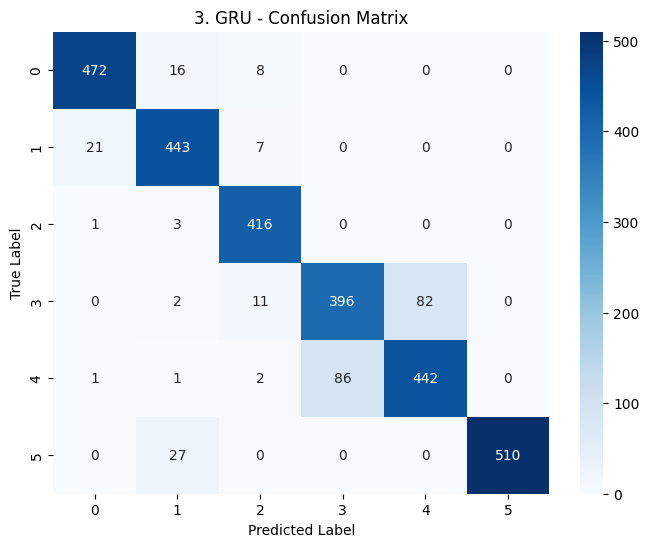


--- 🏋️ Training 4. CNN + LSTM ---
Epoch 01/40 | Train Loss: 1.0179 | Train Acc: 0.5383 | Val Loss: 0.7421 | Val Acc: 0.6349
Epoch 02/40 | Train Loss: 0.6568 | Train Acc: 0.6645 | Val Loss: 0.5994 | Val Acc: 0.6866
Epoch 03/40 | Train Loss: 0.5765 | Train Acc: 0.7359 | Val Loss: 0.4539 | Val Acc: 0.7859
Epoch 04/40 | Train Loss: 0.4324 | Train Acc: 0.8259 | Val Loss: 0.3080 | Val Acc: 0.8980
Epoch 05/40 | Train Loss: 0.2808 | Train Acc: 0.9009 | Val Loss: 0.2584 | Val Acc: 0.9191
Epoch 06/40 | Train Loss: 0.2326 | Train Acc: 0.9199 | Val Loss: 0.1724 | Val Acc: 0.9483
Epoch 07/40 | Train Loss: 0.1798 | Train Acc: 0.9345 | Val Loss: 0.1762 | Val Acc: 0.9320
Epoch 08/40 | Train Loss: 0.1387 | Train Acc: 0.9454 | Val Loss: 0.1374 | Val Acc: 0.9477
Epoch 09/40 | Train Loss: 0.1517 | Train Acc: 0.9452 | Val Loss: 0.1335 | Val Acc: 0.9606
Epoch 10/40 | Train Loss: 0.1480 | Train Acc: 0.9478 | Val Loss: 0.1324 | Val Acc: 0.9565
Epoch 11/40 | Train Loss: 0.1340 | Train Acc: 0.9486 | Val Loss: 

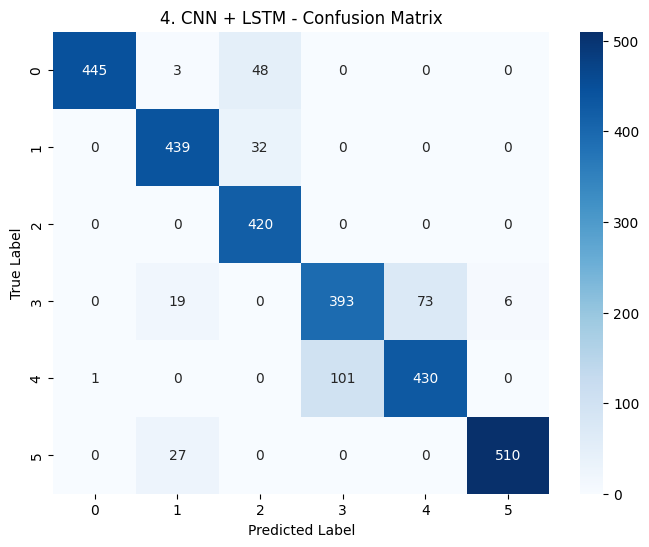


--- 🏋️ Training 5. CNN + GRU ---
Epoch 01/40 | Train Loss: 0.9113 | Train Acc: 0.5956 | Val Loss: 0.4812 | Val Acc: 0.8185
Epoch 02/40 | Train Loss: 0.3844 | Train Acc: 0.8320 | Val Loss: 0.2601 | Val Acc: 0.9028
Epoch 03/40 | Train Loss: 0.2185 | Train Acc: 0.9135 | Val Loss: 0.1983 | Val Acc: 0.9327
Epoch 04/40 | Train Loss: 0.1606 | Train Acc: 0.9408 | Val Loss: 0.2616 | Val Acc: 0.9164
Epoch 05/40 | Train Loss: 0.1354 | Train Acc: 0.9412 | Val Loss: 0.1355 | Val Acc: 0.9483
Epoch 06/40 | Train Loss: 0.1345 | Train Acc: 0.9429 | Val Loss: 0.1322 | Val Acc: 0.9470
Epoch 07/40 | Train Loss: 0.1233 | Train Acc: 0.9486 | Val Loss: 0.1233 | Val Acc: 0.9538
Epoch 08/40 | Train Loss: 0.1230 | Train Acc: 0.9471 | Val Loss: 0.1266 | Val Acc: 0.9545
Epoch 09/40 | Train Loss: 0.1118 | Train Acc: 0.9526 | Val Loss: 0.1100 | Val Acc: 0.9572
Epoch 10/40 | Train Loss: 0.1117 | Train Acc: 0.9537 | Val Loss: 0.1221 | Val Acc: 0.9551
Epoch 11/40 | Train Loss: 0.1232 | Train Acc: 0.9461 | Val Loss: 0

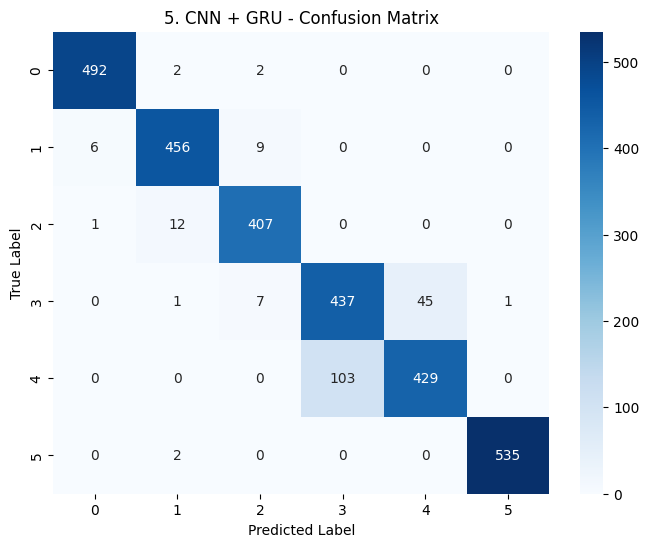


--- 🏋️ Training 6. ResNet1D ---
Epoch 01/40 | Train Loss: 0.3049 | Train Acc: 0.8873 | Val Loss: 0.2876 | Val Acc: 0.9293
Epoch 02/40 | Train Loss: 0.1682 | Train Acc: 0.9340 | Val Loss: 0.1387 | Val Acc: 0.9456
Epoch 03/40 | Train Loss: 0.1731 | Train Acc: 0.9388 | Val Loss: 0.0961 | Val Acc: 0.9646
Epoch 04/40 | Train Loss: 0.1369 | Train Acc: 0.9424 | Val Loss: 0.1173 | Val Acc: 0.9449
Epoch 05/40 | Train Loss: 0.1292 | Train Acc: 0.9464 | Val Loss: 0.1007 | Val Acc: 0.9504
Epoch 06/40 | Train Loss: 0.1229 | Train Acc: 0.9473 | Val Loss: 0.0993 | Val Acc: 0.9626
Epoch 07/40 | Train Loss: 0.1167 | Train Acc: 0.9466 | Val Loss: 0.1424 | Val Acc: 0.9273
Epoch 08/40 | Train Loss: 0.1211 | Train Acc: 0.9500 | Val Loss: 0.0979 | Val Acc: 0.9606
Epoch 09/40 | Train Loss: 0.1222 | Train Acc: 0.9493 | Val Loss: 0.1030 | Val Acc: 0.9592
Epoch 10/40 | Train Loss: 0.1066 | Train Acc: 0.9539 | Val Loss: 0.0793 | Val Acc: 0.9660
Epoch 11/40 | Train Loss: 0.0935 | Train Acc: 0.9599 | Val Loss: 0.

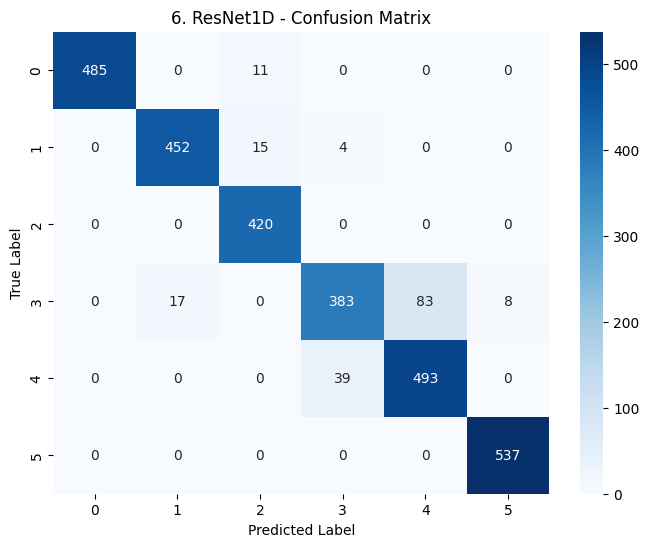


--- 🏋️ Training 7. Transformer ---
Epoch 01/40 | Train Loss: 0.9314 | Train Acc: 0.5882 | Val Loss: 0.4177 | Val Acc: 0.8287
Epoch 02/40 | Train Loss: 0.2889 | Train Acc: 0.8902 | Val Loss: 0.1794 | Val Acc: 0.9266
Epoch 03/40 | Train Loss: 0.1848 | Train Acc: 0.9252 | Val Loss: 0.1384 | Val Acc: 0.9368
Epoch 04/40 | Train Loss: 0.1488 | Train Acc: 0.9391 | Val Loss: 0.1285 | Val Acc: 0.9592
Epoch 05/40 | Train Loss: 0.1380 | Train Acc: 0.9424 | Val Loss: 0.1308 | Val Acc: 0.9551
Epoch 06/40 | Train Loss: 0.1487 | Train Acc: 0.9391 | Val Loss: 0.1472 | Val Acc: 0.9470
Epoch 07/40 | Train Loss: 0.1376 | Train Acc: 0.9407 | Val Loss: 0.1187 | Val Acc: 0.9449
Epoch 08/40 | Train Loss: 0.1187 | Train Acc: 0.9500 | Val Loss: 0.1229 | Val Acc: 0.9415
Epoch 09/40 | Train Loss: 0.1203 | Train Acc: 0.9490 | Val Loss: 0.1285 | Val Acc: 0.9415
Epoch 10/40 | Train Loss: 0.1303 | Train Acc: 0.9469 | Val Loss: 0.1194 | Val Acc: 0.9640
Epoch 11/40 | Train Loss: 0.1192 | Train Acc: 0.9502 | Val Loss:

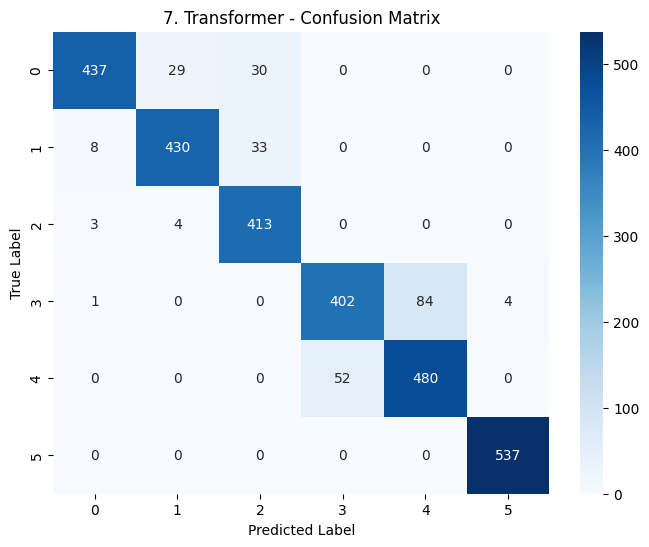

In [30]:
criterion = nn.CrossEntropyLoss()
history = {}

# 각 모델을 순차적으로 학습 및 평가
for model_name, model in models.items():
    print(f"\n--- 🏋️ Training {model_name} ---")
    model = model.to(device)
    # Optimizer를 Adam -> AdamW로 변경, weight_decay 추가
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

    # LR Scheduler 추가
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    best_val_acc = 0.0
    model_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        model_history['train_loss'].append(train_loss)
        model_history['train_acc'].append(train_acc)
        model_history['val_loss'].append(val_loss)
        model_history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:02}/{N_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Scheduler step 추가 (validation loss 기준)
        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # (선택) 최고 성능 모델 저장
            # torch.save(model.state_dict(), f"{model_name.replace(' ', '_')}_best.pth")

    history[model_name] = model_history

    # --- 테스트셋 평가 ---
    print(f"\n--- 📊 Evaluating {model_name} on Test Set ---")
    y_test_true, y_test_pred = get_test_results(model, test_loader, device)

    test_acc = accuracy_score(y_test_true, y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}\n")

    print("Classification Report:")
    # 'zero_division=0'을 추가하여 경고 메시지 대신 0.0으로 처리
    print(classification_report(y_test_true, y_test_pred, digits=4, zero_division=0))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test_true, y_test_pred)
    print(cm)

    # Confusion Matrix 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(6), yticklabels=range(6))
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


--- 📈 All Model Training History ---


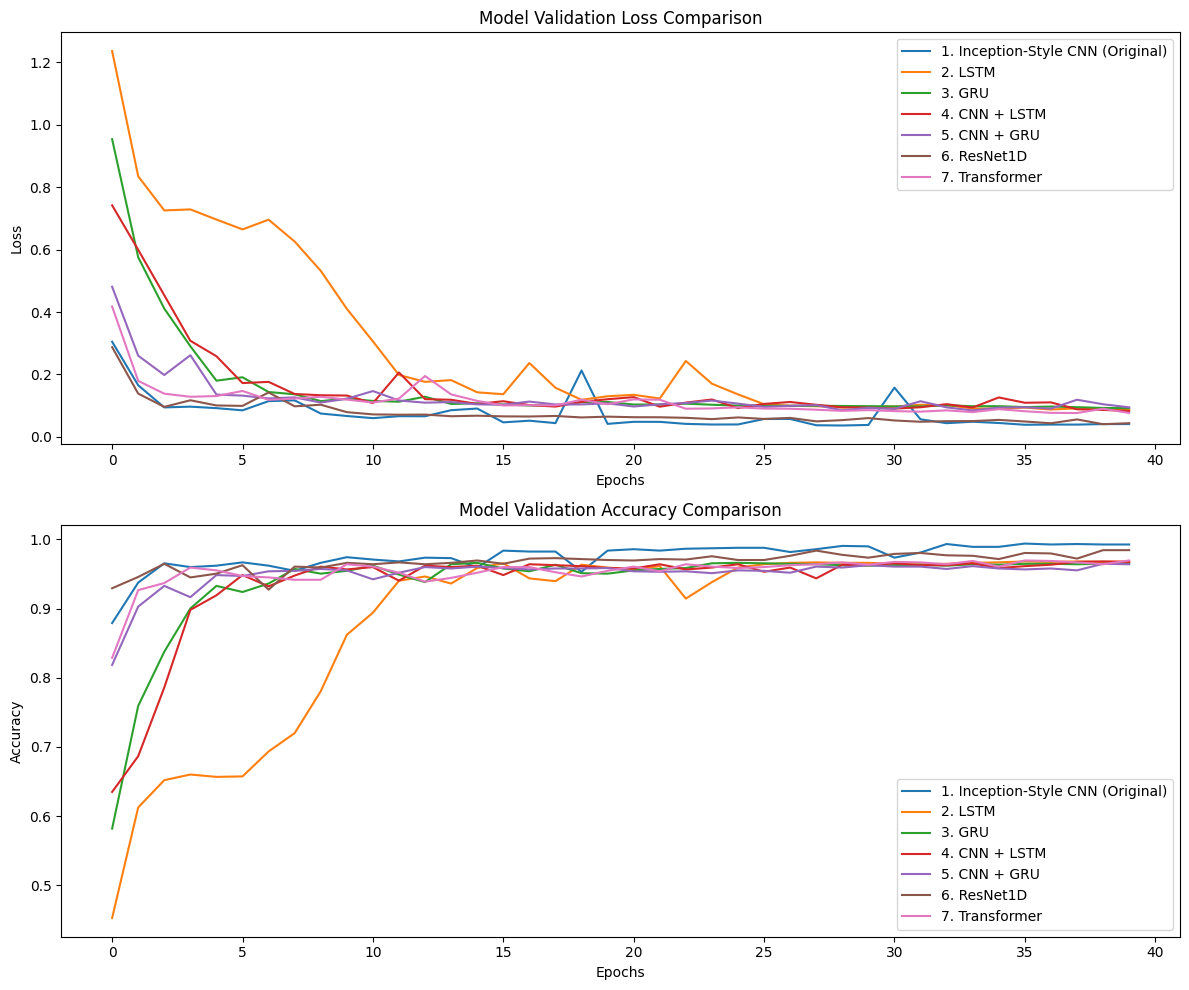

In [31]:
# --- 5. 전체 모델 성능 비교 (학습 곡선) ---
print("\n--- 📈 All Model Training History ---")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Loss 비교
for model_name, h in history.items():
    ax1.plot(h['val_loss'], label=model_name)
ax1.set_title('Model Validation Loss Comparison')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy 비교
for model_name, h in history.items():
    ax2.plot(h['val_acc'], label=model_name)
ax2.set_title('Model Validation Accuracy Comparison')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()